# Zones soumises à un risque d'innondation

#### Imports

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from datetime import datetime, timedelta
import glob
import plotly.graph_objects as go

%matplotlib inline
# Set notebook mode to work in offline
pio.renderers.default = 'iframe+pdf'

#### API STATIONS

On récupères les stations hydrométriques en fonctionnement:

In [2]:
url_stations = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/referentiel/stations"

response_stations = requests.get(url_stations, params={"size": 6000})
if response_stations.status_code == '200' or '206': # status codes are detailed on the website
    data_stations = response_stations.json()
    data_stations = pd.DataFrame(data_stations["data"])
else:
    print(f"La requête a échoué avec le code d'état {response_stations.status_code}")

# We check the names of the columns that contain at least 50% of null values
data_stations.isnull().sum()

# We remove the columns that contain at least 50% of null values
data_stations = data_stations.dropna(axis=1, thresh=int(0.5*len(data_stations)))

# We remove every row that is not in metropolitan france
regions_in_metropolitan_france = ['GRAND EST', 'HAUTS-DE-FRANCE', 'BOURGOGNE-FRANCHE-COMTE', 'ILE-DE-FRANCE', 'CENTRE-VAL DE LOIRE', 'NORMANDIE', 'BRETAGNE', 'PAYS DE LA LOIRE', 'AUVERGNE-RHONE-ALPES', 'OCCITANIE', 'NOUVELLE-AQUITAINE', "PROVENCE-ALPES-COTE D'AZUR", 'CORSE']
data_stations = data_stations[data_stations["libelle_region"].isin(regions_in_metropolitan_france)]

# Next, we remove every row where the corresponding station is not active
data_stations = data_stations[data_stations["en_service"] == True]

# We remove every row where the longitude is between -15 and 40
data_stations = data_stations[(data_stations["longitude_station"] > -15) & (data_stations["longitude_station"] < 40)]

print("Il y a",len(data_stations),"stations en fonctionnement.")

Il y a 3449 stations en fonctionnement.


On sélectionne les stations pour lesquelles on connait:
- les moyennes des observations de débit des 25 dernières années
- les seuils de hauteur limite
- les seuils de débit limite

###### Voir code qui a permis de toutes ces données car pas d'API disponible...

In [3]:
# On récupère les fichiers contenant les moyennes des observations de débit des 25 dernières années

# Les données des stations dont on a pu récupérer ces infos sont enregistrées dans des fichiers csv
dossier = 'data_limites'

fichiers_csv = glob.glob(dossier + '/data*')

codes_sites_A = []
for fichier in fichiers_csv:
    codes_sites_A.append(fichier.split("_")[-1])

print("Il y a",len(codes_sites_A)," stations pour lesquelles on connait la moyenne des observations de débit des 25 dernières années.")

Il y a 2588  stations pour lesquelles on connait la moyenne des observations de débit des 25 dernières années.


In [4]:
# On récupère les seuils limites de hauteur

with open("limites_H.txt",'r') as file:
    seuils_H = {}
    for line in file:
        cle, valeur = line.strip().split(':')        
        seuils_H[cle] = valeur

        
code_sites_H = list(seuils_H.keys())
print("Il y a",len(seuils_H),"stations pour lesquelles on a le seuil limite maximum (hauteur)")

Il y a 2778 stations pour lesquelles on a le seuil limite maximum (hauteur)


In [5]:
#seuils_H

In [6]:
# On récupère les seuils limites de débit

with open("limites_Q.txt",'r') as file:
    seuils_Q = {}
    for line in file:
        cle, valeur = line.strip().split(':')        
        seuils_Q[cle] = valeur

        
code_sites_Q = list(seuils_Q.keys())
print("Il y a",len(seuils_Q),"stations pour lesquelles on a le seuil limite maximum (débit)")

Il y a 2655 stations pour lesquelles on a le seuil limite maximum (débit)


Visualisation des stations:

In [7]:
data_stations_final = data_stations.loc[data_stations['code_station'].isin(codes_sites_A)] # Stations dont on a les observations passées
data_stations_final = data_stations_final.loc[data_stations_final['code_station'].isin(code_sites_H)] # Stations dont on a les seuils_H
data_stations_final = data_stations_final.loc[data_stations_final['code_station'].isin(code_sites_Q)] # Stations dont on a les seuils_Q
print("Il y a",len(data_stations_final)," stations exploitables")

Il y a 2415  stations exploitables


In [8]:
#data_stations_final

In [9]:
fig = px.scatter_mapbox(data_stations_final,lat='latitude_station',lon='longitude_station', zoom=4, center={'lat': 46.5, 'lon': 2.7274})
fig.update_layout(title='Stations exploitables', title_x=0.5, autosize=True, height=800,
                  mapbox_style='carto-positron')
fig.show()

### Trouver les stations qui annoncent un risque de crue:

On récupère les dernières observations hydrométriques de ces stations. (plusieurs requêtes): (l'API utilisée ci dessous ne fournit pas de résultat sur une date antiérieure à un mois de la date actuelle)

In [10]:
url = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/observations_tr"
stations = data_stations_final['code_station'].tolist()

date = datetime.now()-timedelta(hours=12) # On récupères toutes les observations des 24 dernières heures
date = date.strftime("%Y-%m-%dT%H:%M:%S")

data_hydro = pd.DataFrame()
nombre_requetes = 0

for i in range(0,len(stations),75):
    params = {
        "code_entite": stations[i:i+75], # station code    
        "date_debut_obs": date,        
        "grandeur_hydro": ['Q','H'], # hydrometric variables choosen
        "size": 20000
        #"timestep": 20
    }
    
    response = requests.get(url, params=params)

    nombre_requetes+=1
    print(f"Requete {nombre_requetes} : status code:",response.status_code)
    
    if response.status_code == (200 or 206): # status codes are detailed on the website
        data = response.json()        
        data_hydro_temp = pd.DataFrame(data["data"])
        data_hydro = pd.concat([data_hydro,data_hydro_temp], ignore_index=True)
    else:
        print(f"La requête {nombre_requetes} a échoué avec le code d'état {response.status_code}")

Requete 1 : status code: 200
Requete 2 : status code: 200
Requete 3 : status code: 200
Requete 4 : status code: 200
Requete 5 : status code: 200
Requete 6 : status code: 200
Requete 7 : status code: 200
Requete 8 : status code: 200
Requete 9 : status code: 200
Requete 10 : status code: 200
Requete 11 : status code: 200
Requete 12 : status code: 200
Requete 13 : status code: 200
Requete 14 : status code: 200
Requete 15 : status code: 200
Requete 16 : status code: 200
Requete 17 : status code: 200
Requete 18 : status code: 200
Requete 19 : status code: 200
Requete 20 : status code: 200
Requete 21 : status code: 200
Requete 22 : status code: 200
Requete 23 : status code: 200
Requete 24 : status code: 200
Requete 25 : status code: 200
Requete 26 : status code: 200
Requete 27 : status code: 200
Requete 28 : status code: 200
Requete 29 : status code: 200
Requete 30 : status code: 200
Requete 31 : status code: 200
Requete 32 : status code: 200
Requete 33 : status code: 200


OLD: On récupère uniquement la dernière observation pour chaque station:

In [11]:
data_hydro.head()

,code_site,code_station,grandeur_hydro,date_debut_serie,date_fin_serie,statut_serie,code_systeme_alti_serie,date_obs,resultat_obs,code_methode_obs,libelle_methode_obs,code_qualification_obs,libelle_qualification_obs,continuite_obs_hydro,longitude,latitude
0,A4020610,A402061001,H,2023-11-06T00:35:00Z,2023-11-06T11:30:00Z,4,31,2023-11-06T11:30:00Z,498.0,0,Mesure,16,Non qualifiée,True,6.796285,47.866921
1,A4020610,A402061001,Q,2023-11-06T00:35:00Z,2023-11-06T11:30:00Z,4,31,2023-11-06T11:30:00Z,8110.0,12,Interpolation,16,Non qualifiée,True,6.796285,47.866921
2,A4050620,A405062001,H,2023-11-06T00:35:00Z,2023-11-06T11:30:00Z,4,31,2023-11-06T11:30:00Z,1133.0,0,Mesure,16,Non qualifiée,True,6.685918,47.909445
3,A4050620,A405062001,Q,2023-11-06T00:35:00Z,2023-11-06T11:30:00Z,4,31,2023-11-06T11:30:00Z,17700.0,12,Interpolation,16,Non qualifiée,True,6.685918,47.909445
4,A4140202,A414020201,H,2023-11-06T00:35:00Z,2023-11-06T11:30:00Z,4,31,2023-11-06T11:30:00Z,1240.0,0,Mesure,16,Non qualifiée,True,6.715933,47.993393


In [12]:
# On supprime les mesures qualifiées de "douteuses"

data_hydro = data_hydro.drop(data_hydro.loc[data_hydro['libelle_qualification_obs'] == 'Douteuse'].index)

On fait la moyenne des observations:

In [13]:
mean_obs = data_hydro.groupby(["code_station","grandeur_hydro"])[['resultat_obs','latitude','longitude']].mean().reset_index()
mean_obs_H = mean_obs.loc[mean_obs["grandeur_hydro"] == 'H'].reset_index()
mean_obs_Q = mean_obs.loc[mean_obs["grandeur_hydro"] == 'Q'].reset_index()

In [14]:
mean_obs #-----------------------------------

,code_station,grandeur_hydro,resultat_obs,latitude,longitude
0,A022020001,H,238.126984,47.564377,7.528982
1,A053074201,H,271.031746,48.296112,7.654202
2,A053074201,Q,226.777778,48.296112,7.654202
3,A061005051,H,1343.603175,48.592540,7.802871
4,A100003001,H,322.904762,47.488084,7.392949
...,...,...,...,...,...
4129,Y921000203,H,601.789474,42.229485,9.437795
4130,Y941000102,H,1165.025000,42.103244,9.260356
4131,Y960000102,H,955.452381,41.863776,9.370376
4132,Y980000302,H,1517.984733,41.596406,9.237163


On regarde les stations dont les observations de débit sont 1.5x supérieures aux moyenens de saisons:

In [15]:
data_hydro_ALERT1 = pd.DataFrame()

for index, row in mean_obs_Q.iterrows():
    code_station = row['code_station']
    mois_actuel = datetime.now().month
    
    try:
        data_station = pd.read_csv(f'data_limites/data_limites_{code_station}')
        data_station['QmM  Débit moyen mensuel (en l/s)'] = data_station['QmM  Débit moyen mensuel (en l/s)'].astype(int)        
        moyenne_mois_acutel = data_station.iloc[mois_actuel]['QmM  Débit moyen mensuel (en l/s)']
            
        if row['resultat_obs'] > moyenne_mois_acutel*1.5:
            data_hydro_ALERT1 = pd.concat([data_hydro_ALERT1,mean_obs_Q.loc[mean_obs_Q['code_station']==row['code_station']]],ignore_index=True)
            
    except:
        pass
        

On regarde les stations où la hauteur d'eau est à 60% du seuil:

In [16]:
data_hydro_ALERT2 = pd.DataFrame()

for index, row in mean_obs_H.iterrows():
    
    if row['resultat_obs'] > float(seuils_H[row['code_station']])*0.6:
        data_hydro_ALERT2 = pd.concat([data_hydro_ALERT2,mean_obs_H.loc[mean_obs_H['code_station']==row['code_station']]],ignore_index=True)


In [17]:
 data_hydro_ALERT2 #------------------------------------------

,index,code_station,grandeur_hydro,resultat_obs,latitude,longitude
0,71,A226032002,H,1187.079365,48.571809,7.724608
1,85,A243003001,H,1389.920635,48.488762,7.704857
2,99,A302009050,H,5184.730159,48.958118,8.195814
3,241,A842020101,H,719.908397,49.285515,6.003351
4,424,E351122001,H,1391.937984,50.618625,2.215236
...,...,...,...,...,...,...
243,3774,X102691001,H,232.238095,44.543873,5.823364
244,3793,X331001001,H,3038.679389,43.827487,5.032432
245,3800,X350001001,H,3491.832061,43.888799,4.923197
246,3964,Y258002002,H,7585.348485,43.338453,3.208215


On regarde les stations où le débit est à 60% du seuil:

In [18]:
data_hydro_ALERT3 = pd.DataFrame()

for index, row in mean_obs_Q.iterrows():
    
    if row['resultat_obs'] > float(seuils_Q[row['code_station']])*0.6:
        data_hydro_ALERT3 = pd.concat([data_hydro_ALERT3,mean_obs_Q.loc[mean_obs_Q['code_station']==row['code_station']]],ignore_index=True)


On récupère les stations qui on passé les 3 alertes

In [19]:
data_hydro_ALERT_merged1 = data_hydro_ALERT2[['code_station','latitude','longitude']].merge(data_hydro_ALERT3[['code_station','latitude','longitude']], how='inner', on=['code_station','latitude','longitude'])
data_hydro_ALERT_merged2 = pd.merge(data_hydro_ALERT_merged1[['code_station','latitude','longitude']], data_hydro_ALERT1[['code_station','latitude','longitude']], how='inner', on=['code_station','latitude','longitude'])
data_hydro_ALERT_all = pd.merge(data_hydro_ALERT1[['code_station','latitude','longitude']], data_hydro_ALERT2[['code_station','latitude','longitude']], how='outer', on=['code_station','latitude','longitude'])
data_hydro_ALERT_all = pd.merge(data_hydro_ALERT_all[['code_station','latitude','longitude']], data_hydro_ALERT3[['code_station','latitude','longitude']], how='outer', on=['code_station','latitude','longitude'])


Visualisation de ces stations:

In [20]:
fig = px.scatter_mapbox(data_stations_final,lat='latitude_station',lon='longitude_station', zoom=4, center={'lat': 46.5, 'lon': 2.7274})
fig.update_traces(marker=dict(color='rgba(0, 171, 0, 1)'))
fig.update_layout(title='Zones à risque - <span style="color:red">●</span>: 3 variables <span style="color:orange">●</span>: 2 variables <span style="color:yellow">●</span>: 1 variable <span style="color:green">●</span>: RAS', title_x=0.5, autosize=True, height=800,
                  mapbox_style='carto-positron')

fig0 = px.scatter_mapbox(data_hydro_ALERT_all, lat='latitude', lon='longitude', zoom=4, center={'lat': 46.5, 'lon': 2.7274}) 
fig0.update_traces(marker=dict(color='rgba(245, 229, 0, 1)',size=10))

fig1 = px.scatter_mapbox(data_hydro_ALERT_merged1, lat='latitude', lon='longitude', zoom=4, center={'lat': 46.5, 'lon': 2.7274}) 
fig1.update_traces(marker=dict(color='rgba(255, 150, 0, 1)',size=10))

fig2 = px.scatter_mapbox(data_hydro_ALERT_merged2, lat='latitude', lon='longitude', zoom=4, center={'lat': 46.5, 'lon': 2.7274}) 
fig2.update_traces(marker=dict(color='red',size=10))

for trace in fig0.data:
    fig.add_trace(trace)

for trace in fig1.data:
    fig.add_trace(trace)

for trace in fig2.data:
    fig.add_trace(trace)

fig.show()

Comparaison entre les observations et les seuils de hauteur et de débit:

/var/folders/1k/01cdbyq56g1d70jhj94cyzg00000gn/T/ipykernel_3385/1356197424.py:30: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



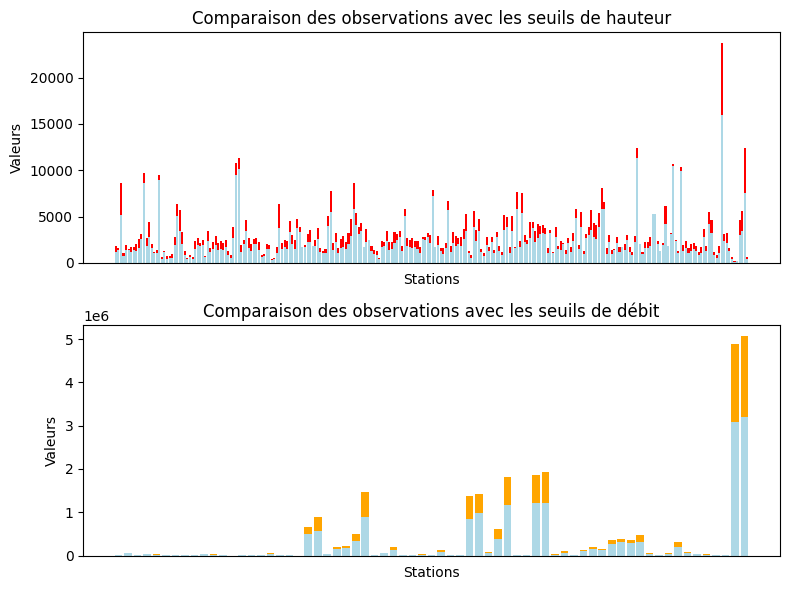

In [21]:
seuils_H_temp = {}
for code in data_hydro_ALERT2['code_station']:
    seuils_H_temp[code] = seuils_H[code]
seuils_H_df = pd.DataFrame.from_dict(seuils_H_temp, orient='index', columns=['Seuils']).reset_index()
seuils_H_df['Seuils'] =seuils_H_df['Seuils'].astype(int)

seuils_Q_temp = {}
for code in data_hydro_ALERT3['code_station']:
    seuils_Q_temp[code] = seuils_Q[code]
seuils_Q_df = pd.DataFrame.from_dict(seuils_Q_temp, orient='index', columns=['Seuils']).reset_index()
seuils_Q_df['Seuils'] = seuils_Q_df['Seuils'].astype(int)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

ax1.bar(seuils_H_df['index'], seuils_H_df['Seuils'], color='red')
ax1.bar(data_hydro_ALERT2['code_station'], data_hydro_ALERT2['resultat_obs'], color='lightblue')
ax1.set_title('Comparaison des observations avec les seuils de hauteur')
ax1.set_xticks([])
ax1.set_xlabel('Stations')
ax1.set_ylabel('Valeurs')

ax2.bar(seuils_Q_df['index'], seuils_Q_df['Seuils'], color='orange')
ax2.bar(data_hydro_ALERT3['code_station'], data_hydro_ALERT3['resultat_obs'], color='lightblue')
ax2.set_title('Comparaison des observations avec les seuils de débit')
ax2.set_xticks([])
ax2.set_xlabel('Stations')
ax2.set_ylabel('Valeurs')

fig.tight_layout()
fig.show()

### Comparaison avec une ancienne crue (2003):

Test avec une autre API pour comparer avec des crues historiques: (seul les infos de débit sont dispo sur cette api)

In [22]:
url2 = "http://hubeau.eaufrance.fr/api/v1/hydrometrie/obs_elab"
stations = data_stations_final['code_station'].tolist()

date_deb_crue = datetime(2003, 12, 3)
date_fin_crue = datetime(2003, 12, 4)

data_hydro2 = pd.DataFrame()

for i in range(0,len(stations),99):
    params = {
        "code_entite": stations[i:i+99], # station code    
        "date_debut_obs_elab": date_deb_crue,
        "date_fin_obs_elab": date_fin_crue,
        "grandeur_hydro_elab": ['QmJ'], # hydrometric variables choosen
        "size": 20000,
        "resultat_min": 0
        #"timestep": 20
    }
    
    response = requests.get(url2, params=params)
    
    print("status code:",response.status_code)
    
    if response.status_code == (200 or 206): # status codes are detailed on the website
        data = response.json()        
        data_hydro_temp = pd.DataFrame(data["data"])
        data_hydro2 = pd.concat([data_hydro2,data_hydro_temp], ignore_index=True)
    else:
        print(f"La requête a échoué avec le code d'état {response.status_code}")

status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200
status code: 200


In [24]:
# On supprime les mesures qualifiées de "douteuses"

data_hydro2 = data_hydro2.drop(data_hydro2.loc[data_hydro2['libelle_qualification'] == 'Douteuse'].index)

In [26]:
mean_obs = data_hydro2.groupby(["code_station"])[['resultat_obs_elab','latitude','longitude']].mean().reset_index()

In [ ]:
#-------------------------------------------------------------------------------------------------------------

In [35]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

# Filter rows where the "latitude" column is equal to 47.55555
filtered_rows = mean_obs[mean_obs['latitude'] > 47.5]
# Convert the filtered DataFrame to a string
email_body = filtered_rows.to_string(index=False)
# Iniciamos los parámetros del script
remitente = 'avela1615@gmail.com'
destinatarios = ['avela1615@gmail.com','alan94roma@gmail.com']
asunto = '[RPI] Latitude '
cuerpo = email_body

# Creamos el objeto mensaje
mensaje = MIMEMultipart()
 
# Establecemos los atributos del mensaje
mensaje['From'] = remitente
mensaje['To'] = ", ".join(destinatarios)
mensaje['Subject'] = asunto

# Agregamos el cuerpo del mensaje como objeto MIME de tipo texto
mensaje.attach(MIMEText(cuerpo, 'plain'))

# Creamos la conexión con el servidor
sesion_smtp = smtplib.SMTP('smtp.gmail.com', 587)

# Ciframos la conexión
sesion_smtp.starttls()

# Iniciamos sesión en el servidor
sesion_smtp.login('avela1615@gmail.com','ask me the password')

# Convertimos el objeto mensaje a texto
texto = mensaje.as_string()

# Enviamos el mensaje
sesion_smtp.sendmail(remitente, destinatarios, texto)

# Cerramos la conexión
sesion_smtp.quit()

In [ ]:
#--------------------------------------------------------------------------------

On regarde les stations dont le débit d'eau est 1.5x au dessus des moyennes de saison:

In [ ]:
data_hydro_ALERT1 = pd.DataFrame()

for index, row in mean_obs.iterrows():
    code_station = row['code_station']
    mois = 11
    
    try:
        data_station = pd.read_csv(f'data_limites/data_limites_{code_station}')
        data_station['QmM  Débit moyen mensuel (en l/s)'] = data_station['QmM  Débit moyen mensuel (en l/s)'].astype(int)        
        moyenne_mois = data_station.iloc[mois]['QmM  Débit moyen mensuel (en l/s)']
            
        if row['resultat_obs_elab'] > moyenne_mois*3:
            data_hydro_ALERT1 = pd.concat([data_hydro_ALERT1,mean_obs.loc[mean_obs['code_station']==row['code_station']]],ignore_index=True)
            
    except:
        pass
        

In [ ]:
data_station

(PAS UTILISE) On regarde les stations où le débit est à 60% du seuil:

Visualisation de ces stations

In [ ]:
fig = px.scatter_mapbox(data_stations_final,lat='latitude_station',lon='longitude_station', zoom=4, center={'lat': 46.5, 'lon': 2.7274})
fig.update_traces(marker=dict(color='rgba(0, 171, 0, 1)'))
fig.update_layout(title='Zones à risque - <span style="color:orange">●</span>: 2 variables <span style="color:yellow">●</span>: 1 variable <span style="color:green">●</span>: RAS', title_x=0.5, autosize=True, height=800,
                  mapbox_style='carto-positron')

fig0 = px.scatter_mapbox(data_hydro_ALERT1, lat='latitude', lon='longitude', zoom=4, center={'lat': 46.5, 'lon': 2.7274}) 
fig0.update_traces(marker=dict(color='red',size=8))

for trace in fig0.data:
    fig.add_trace(trace)

fig.show()

Pour comparer: (carte meteo france)

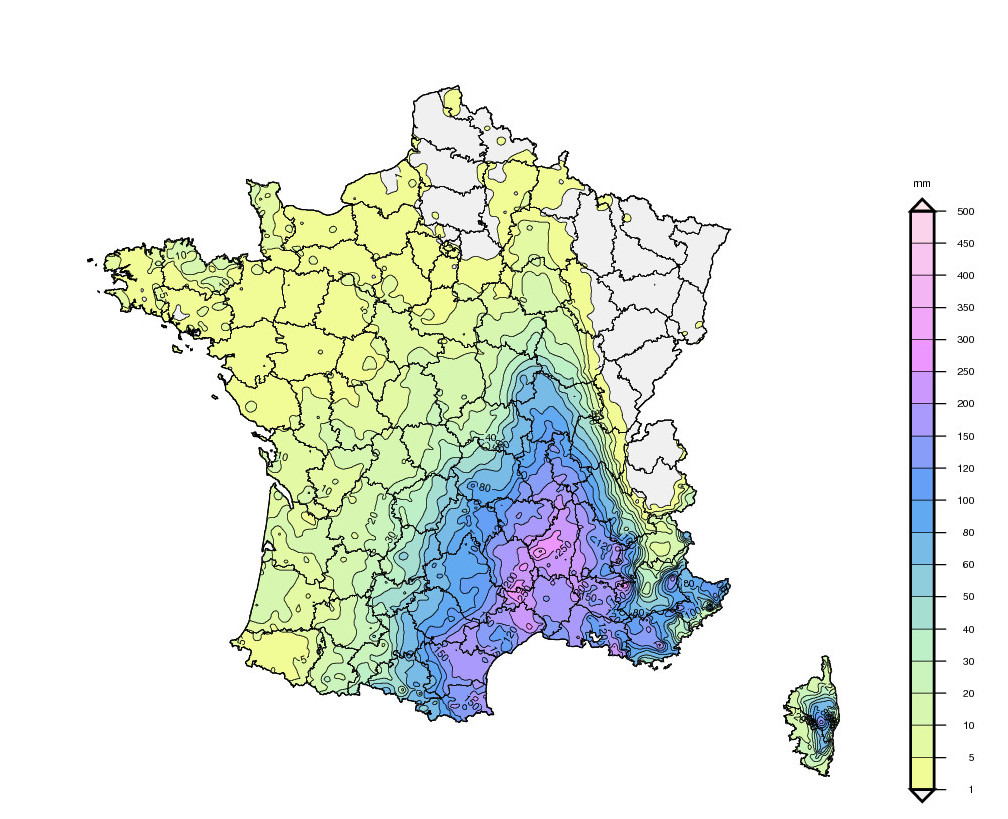